In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
batch_size = 64
seed = 123
train_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size, validation_split=0.2,
    subset='training', seed=seed
)
test_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed
)
train_dataset.element_spec

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:3])
    print('label: ', label.numpy()[:3])

text:  [b"I have watched this movie well over 100-200 times, and I love it each and every time I watched it. Yes, it can be very corny but it is also very funny and enjoyable. The camp shown in the movie is a real camp that I actually attended for 7 years and is portrayed as camp really is, a great place to spend the summer. Everyone who has ever gone to camp, wanted to go to camp, or has sent a child to camp should see this movie because it'll bring back wonderful memories for you and for your kids."
 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without all the annoying songs). The songs that are sung are likable; you might even find yourself singing these songs once the movie is through. T

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  26, 279, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0],
       [ 10, 209,   1, ...,   0,   0,   0]], dtype=int64)

In [9]:
for n in range(3):
    print('Original: ', example[n].numpy())
    print('Round-trip: ', ' '.join(vocab[encoded_example[n]]))

Original:  b"I have watched this movie well over 100-200 times, and I love it each and every time I watched it. Yes, it can be very corny but it is also very funny and enjoyable. The camp shown in the movie is a real camp that I actually attended for 7 years and is portrayed as camp really is, a great place to spend the summer. Everyone who has ever gone to camp, wanted to go to camp, or has sent a child to camp should see this movie because it'll bring back wonderful memories for you and for your kids."
Round-trip:  i have watched this movie well over [UNK] times and i love it each and every time i watched it yes it can be very [UNK] but it is also very funny and enjoyable the [UNK] shown in the movie is a real [UNK] that i actually [UNK] for [UNK] years and is portrayed as [UNK] really is a great place to [UNK] the [UNK] everyone who has ever gone to [UNK] wanted to go to [UNK] or has [UNK] a child to [UNK] should see this movie because [UNK] bring back wonderful [UNK] for you and fo

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.0016519]


In [13]:
padding = 'the ' * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.0016519]


In [14]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer = tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

In [15]:
with tf.device('cpu:0'):
    history = model.fit(train_dataset, epochs=10,
                    validation_data = test_dataset,
                    validation_steps=30)

Epoch 1/10
313/313 [==============================] - 445s 1s/step - loss: 0.6780 - accuracy: 0.5217 - val_loss: 0.5951 - val_accuracy: 0.6047
Epoch 2/10
313/313 [==============================] - 438s 1s/step - loss: 0.4496 - accuracy: 0.7794 - val_loss: 0.3769 - val_accuracy: 0.8224
Epoch 3/10
313/313 [==============================] - 435s 1s/step - loss: 0.3563 - accuracy: 0.8406 - val_loss: 0.3964 - val_accuracy: 0.7917
Epoch 4/10
313/313 [==============================] - 478s 2s/step - loss: 0.3316 - accuracy: 0.8543 - val_loss: 0.3540 - val_accuracy: 0.8516
Epoch 5/10
313/313 [==============================] - 434s 1s/step - loss: 0.3188 - accuracy: 0.8622 - val_loss: 0.3452 - val_accuracy: 0.8526
Epoch 6/10
313/313 [==============================] - 432s 1s/step - loss: 0.3118 - accuracy: 0.8649 - val_loss: 0.3401 - val_accuracy: 0.8484
Epoch 7/10
313/313 [==============================] - 442s 1s/step - loss: 0.3069 - accuracy: 0.8680 - val_loss: 0.3518 - val_accuracy: 0.8443

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print("Test Accuracy: {}".format(test_acc))

79/79 [==============================] - 4s 56ms/step - loss: 0.3362 - accuracy: 0.8544
Test Loss: 0.3362452983856201
Test Accuracy: 0.8543999791145325


(0.0, 0.696829417347908)

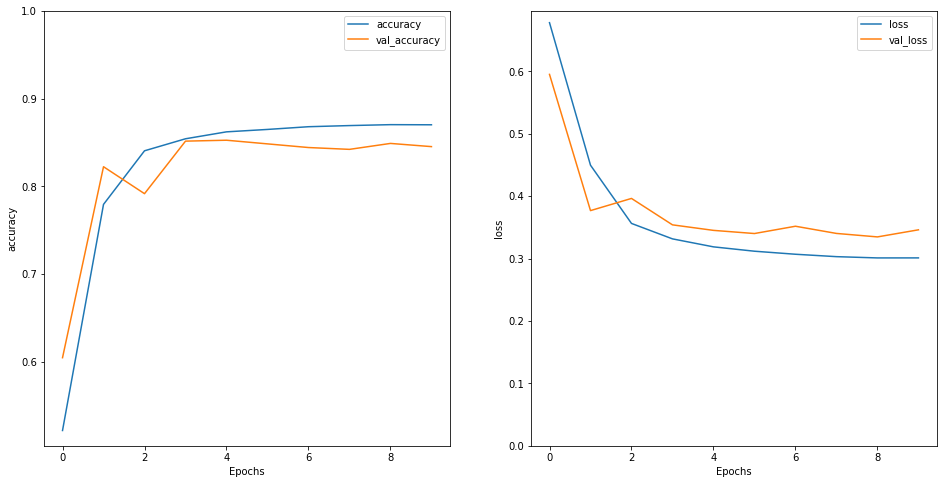

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
with tf.device('cpu:0'):
    history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
313/313 [==============================] - 664s 2s/step - loss: 0.6705 - accuracy: 0.5318 - val_loss: 0.5958 - val_accuracy: 0.7115
Epoch 2/10
313/313 [==============================] - 761s 2s/step - loss: 0.4417 - accuracy: 0.7901 - val_loss: 0.3869 - val_accuracy: 0.8281
Epoch 3/10
313/313 [==============================] - 732s 2s/step - loss: 0.3606 - accuracy: 0.8424 - val_loss: 0.3947 - val_accuracy: 0.8208
Epoch 4/10
313/313 [==============================] - 721s 2s/step - loss: 0.3294 - accuracy: 0.8589 - val_loss: 0.3854 - val_accuracy: 0.8167
Epoch 5/10
313/313 [==============================] - 730s 2s/step - loss: 0.3300 - accuracy: 0.8560 - val_loss: 0.3523 - val_accuracy: 0.8432
Epoch 6/10
313/313 [==============================] - 733s 2s/step - loss: 0.3168 - accuracy: 0.8653 - val_loss: 0.3397 - val_accuracy: 0.8495
Epoch 7/10
313/313 [==============================] - 737s 2s/step - loss: 0.3074 - accuracy: 0.8696 - val_loss: 0.3293 - val_accuracy: 0.8557

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print("Test Accuracy: {}".format(test_acc))

79/79 [==============================] - 6s 81ms/step - loss: 0.3198 - accuracy: 0.8632
Test Loss: 0.319803386926651
Test Accuracy: 0.8632000088691711


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.5591979]]


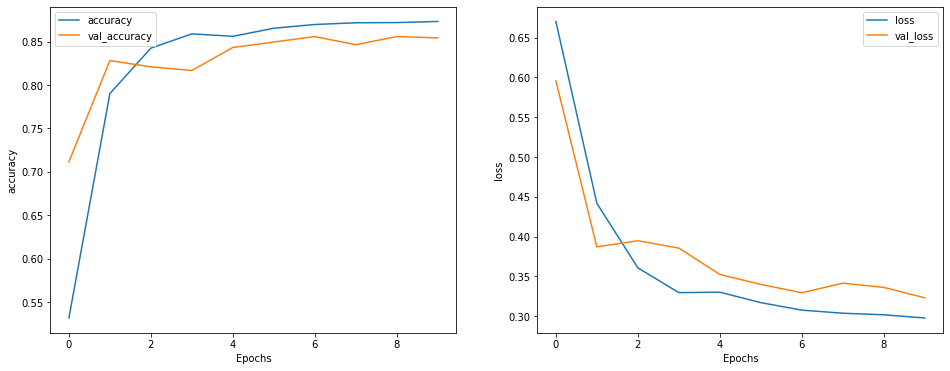

In [24]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')